In [4]:
import numpy as np 
import pandas as pd 
import json 
from geopy.geocoders import Nominatim
import geocoder 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import requests
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

print("Libraries imported.")

Libraries imported.


Importing our data.

In [5]:
df_raw = pd.read_csv("1000-largest-us-cities-by-population-with-geographic-coordinates.csv", sep=';')

In [6]:
df_raw.head()
df_raw

City  Rank           State  Growth From 2000 to 2013  \
0       Marysville   552      Washington                     115.7   
1           Perris   466      California                      98.7   
2        Cleveland    48            Ohio                     -18.1   
3        Worcester   129   Massachusetts                       5.8   
4         Columbia   192  South Carolina                      11.7   
..             ...   ...             ...                       ...   
995  Santa Barbara   339      California                       0.9   
996        Addison   986        Illinois                       2.6   
997     Rio Rancho   329      New Mexico                      74.4   
998         Normal   671        Illinois                      19.7   
999     Romeoville   931        Illinois                      79.5   

     Population              Coordinates  
0         63269  48.0517637,-122.1770818  
1         72326  33.7825194,-117.2286478  
2        390113     41.49932,-81.6943605  
3        182544   42.2625932,-71.8022934  
4        133358   34.0007104,-81.0348144  
..          ...                      ...  
995       90412  34.4208305,-119.6981901  
996       37385    41.931696,-87.9889556  
997       91956  35.2327544,-106.6630437  
998       54664   40.5142026,-88.9906312  
999       39650   41.6475306,-88.0895061  

[1000 rows x 6 columns]

Splitting the coordinates column into two columns.

In [7]:
split_data = df_raw["Coordinates"].str.split(",")
data = split_data.to_list()
names = ["Latitude", "Longitude"]
new_df = pd.DataFrame(data, columns=names).apply(pd.to_numeric)

df_cities = df_raw.drop("Coordinates", 1).join(new_df)
df_cities.head()

City  Rank           State  Growth From 2000 to 2013  Population  \
0  Marysville   552      Washington                     115.7       63269   
1      Perris   466      California                      98.7       72326   
2   Cleveland    48            Ohio                     -18.1      390113   
3   Worcester   129   Massachusetts                       5.8      182544   
4    Columbia   192  South Carolina                      11.7      133358   

    Latitude   Longitude  
0  48.051764 -122.177082  
1  33.782519 -117.228648  
2  41.499320  -81.694361  
3  42.262593  -71.802293  
4  34.000710  -81.034814

Mapping out all the cities.

In [8]:
address = 'USA'

geolocator = Nominatim(user_agent="usa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the USA are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the USA are 39.7837304, -100.4458825.


In [9]:
map_usa = folium.Map(location=[latitude, longitude], zoom_start=3)

for lat, lng, city, state in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City'], df_cities['State']):
    label = '{}, {}'.format(city, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#005b96',
        fill=True,
        fill_color='#b3cde0',
        fill_opacity= 0.5,
        parse_html=False).add_to(map_usa)  
    
map_usa

We will query the 200 resturants closest to the centre of each city using the Foursquare API.

In [66]:
CLIENT_ID = 'VYLFQ02EYZHFIT3YVCSJNZNWMQPRPGHZKLHHURXHKE0QZPQQ' 
CLIENT_SECRET = 'Redacted'
VERSION = '20180605' 
LIMIT = 200
CATEGORY_ID = '4d4b7105d754a06374d81259'

In [184]:
def getNearbyRestaurants(names, latitudes, longitudes, radius=20000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng,
                CATEGORY_ID,
                radius, 
                LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    df_restaurants = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_restaurants.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Restaurant', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category']
    
    
    return(df_restaurants)

In [185]:
df_restaurants = getNearbyRestaurants(names=df_cities['City'],
                                   latitudes=df_cities['Latitude'],
                                   longitudes=df_cities['Longitude']
                                  )

In [186]:
df_restaurants.head()

City  City Latitude  City Longitude              Restaurant  \
0  Marysville      48.051764     -122.177082   Cristiano's Pizza Etc   
1  Marysville      48.051764     -122.177082               MOD Pizza   
2  Marysville      48.051764     -122.177082  Jeff's Texas Style BBQ   
3  Marysville      48.051764     -122.177082           Teriyaki Bowl   
4  Marysville      48.051764     -122.177082           Tres Hermanos   

   Restaurant Latitude  Restaurant Longitude Restaurant Category  
0            48.061627           -122.175588         Pizza Place  
1            48.051566           -122.177439         Pizza Place  
2            48.079681           -122.175354           BBQ Joint  
3            48.052631           -122.178036  Chinese Restaurant  
4            48.101007           -122.174620  Mexican Restaurant

First, let us see how many restaurants we have found in each city.

In [187]:
df_restaurants_grouped = df_restaurants.groupby('City').count()[['Restaurant']]
df_restaurants_grouped.columns = ["Restaurant Count"]
df_restaurants_grouped 

Restaurant Count
City                        
Abilene                   91
Addison                  100
Akron                    100
Alameda                  100
Albany                   270
...                      ...
York                     100
Youngstown               100
Yuba City                100
Yucaipa                  100
Yuma                     100

[925 rows x 1 columns]

We notice that we have lost 75 cities. This is probably because Foursquare does not have data for those cities. However this is no problem, 925 cities will be more than enough.

We will now visualize the data have found. We will first show the number of resturants found per state.

In [188]:
df_counts = df_cities.join(df_restaurants_grouped , on='City')
df_counts.head()

City  Rank           State  Growth From 2000 to 2013  Population  \
0  Marysville   552      Washington                     115.7       63269   
1      Perris   466      California                      98.7       72326   
2   Cleveland    48            Ohio                     -18.1      390113   
3   Worcester   129   Massachusetts                       5.8      182544   
4    Columbia   192  South Carolina                      11.7      133358   

    Latitude   Longitude  Restaurant Count  
0  48.051764 -122.177082               100  
1  33.782519 -117.228648               100  
2  41.499320  -81.694361               200  
3  42.262593  -71.802293               100  
4  34.000710  -81.034814               200

In [190]:
df_counts_by_state = df_counts[['State', 'Restaurant Count', 'Population']].groupby('State').sum()
df_counts_by_state = df_counts_by_state.reset_index()
df_counts_by_state.head()

State  Restaurant Count  Population
0     Alabama              1615     1279813
1      Alaska               100      300950
2     Arizona              2436     4691466
3    Arkansas               995      787011
4  California             23291    27910620

Let us display the ratio of the population of the cities of each state to how many restaurants we found using a Cholropleth map. 

In [191]:
df_ratio = pd.DataFrame(df_counts_by_state['Population'] / df_counts_by_state['Restaurant Count'])
df_ratio.columns = ["Ratio"]
df_counts_by_state = df_counts_by_state.join(df_ratio)
df_counts_by_state

State  Restaurant Count  Population        Ratio
0                Alabama              1615     1279813   792.453870
1                 Alaska               100      300950  3009.500000
2                Arizona              2436     4691466  1925.889163
3               Arkansas               995      787011   790.965829
4             California             23291    27910620  1198.343566
5               Colorado              2573     3012284  1170.728333
6            Connecticut              1700     1239817   729.304118
7               Delaware               260      108891   418.811538
8   District of Columbia               100      646449  6464.490000
9                Florida              7439     7410114   996.116951
10               Georgia              2300     1995615   867.658696
11                Hawaii               100      347884  3478.840000
12                 Idaho               727      638333   878.037139
13              Illinois              6161     6055539   982.882487
14               Indiana              2590     2393472   924.120463
15                  Iowa              1216     1037690   853.363487
16                Kansas              1275     1327215  1040.952941
17              Kentucky               437     1079181  2469.521739
18             Louisiana              1092     1238263  1133.940476
19                 Maine               200       66318   331.590000
20              Maryland               690      954852  1383.843478
21         Massachusetts              4447     3007084   676.205082
22              Michigan              3438     2979267   866.569808
23             Minnesota              2813     2055749   730.803057
24           Mississippi               732      427944   584.622951
25              Missouri              2052     1843953   898.612573
26               Montana               286      277392   969.902098
27              Nebraska               556      807304  1451.985612
28                Nevada               600     1481832  2469.720000
29         New Hampshire               500      239934   479.868000
30            New Jersey              2594     1859793   716.959522
31            New Mexico               718      953296  1327.710306
32              New York              2052     9933332  4840.805068
33        North Carolina              2798     3358746  1200.409578
34          North Dakota               251      281945  1123.286853
35                  Ohio              5157     3480839   674.973628
36              Oklahoma               939     1666530  1774.792332
37                Oregon              2186     1680656   768.827081
38          Pennsylvania              1537     2598080  1690.357840
39          Rhode Island               600      499878   833.130000
40        South Carolina              1564      812734   519.650895
41          South Dakota               174      235488  1353.379310
42             Tennessee              2172     2483464  1143.399632
43                 Texas              8840    14836230  1678.306561
44                  Utah              1785     1440569   807.041457
45               Vermont               200       42284   211.420000
46              Virginia              1947     2236964  1148.928608
47            Washington              3330     2956938   887.969369
48         West Virginia               300       99998   333.326667
49             Wisconsin              2003     1910367   953.752871
50               Wyoming               122      122076  1000.622951

In [192]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

threshold_scale = np.linspace(df_counts_by_state['Ratio'].min(),
                              df_counts_by_state['Ratio'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() 
threshold_scale[-1] = threshold_scale[-1] + 1 

m.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_counts_by_state,
    columns=['State', 'Ratio'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population per restaurant found'
)

m




We will now graph the most common types of restaurants found.

In [193]:
df_types = df_restaurants.groupby('Restaurant Category', sort='true').count()[['Restaurant']]
df_types.columns = ["Type Count"]
df_types.sort_values('Type Count', ascending=False, inplace=True)
df_types = df_types.reset_index()
df_types.head()

Restaurant Category  Type Count
0          Pizza Place        8433
1   Mexican Restaurant        8202
2  American Restaurant        8148
3       Sandwich Place        5310
4   Italian Restaurant        4827

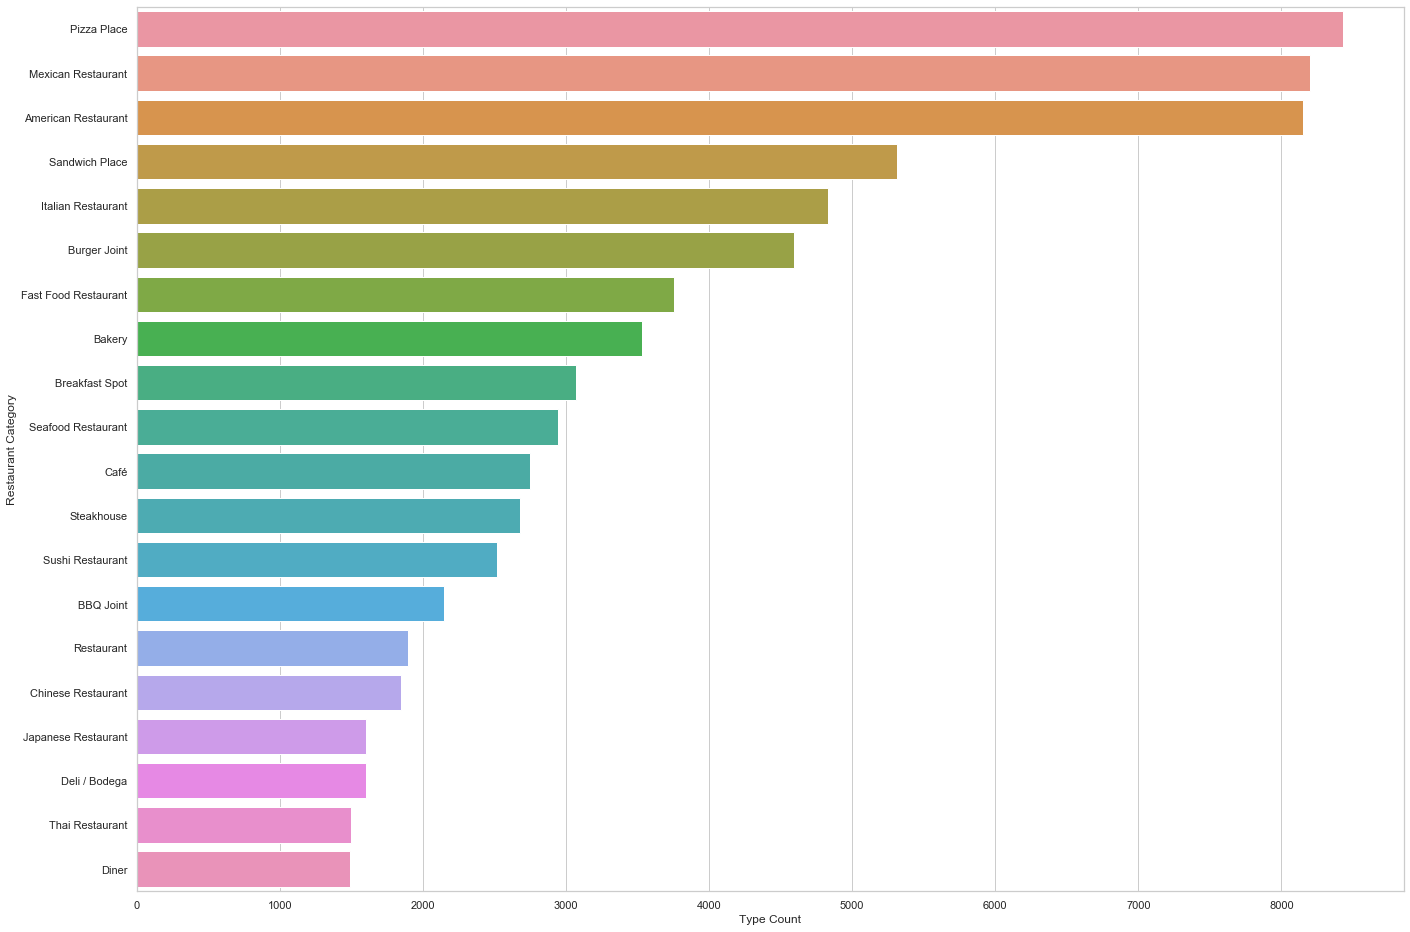

In [194]:
sns.set(rc={'figure.figsize':(22.7,16.27)})
sns.set(style="whitegrid")
ax = sns.barplot(x="Type Count", y="Restaurant Category", data=df_types.head(20))

In [195]:
print('There are {} unique categories of venues.'.format(len(df_restaurants['Restaurant Category'].unique())))

There are 143 unique categories of venues.


We will proceed to cluster these cities. We will preprocess our data. First we transform our resturants dataframe into one-hot vector form.

In [196]:
# one hot encoding
df_onehot = pd.get_dummies(df_restaurants[['Restaurant Category']], prefix="", prefix_sep="")

# add city column back to dataframe
df_onehot['City'] = df_restaurants['City'] 

# move city column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

City  Afghan Restaurant  African Restaurant  American Restaurant  \
0  Marysville                  0                   0                    0   
1  Marysville                  0                   0                    0   
2  Marysville                  0                   0                    0   
3  Marysville                  0                   0                    0   
4  Marysville                  0                   0                    0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                 0                       0                 0   
1                 0                       0                 0   
2                 0                       0                 0   
3                 0                       0                 0   
4                 0                       0                 0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  ...  \
0                      0                    0          0  ...   
1                      0                    0          0  ...   
2                      0                    0          1  ...   
3                      0                    0          0  ...   
4                      0                    0          0  ...   

   Theme Restaurant  Tibetan Restaurant  Trattoria/Osteria  Truck Stop  \
0                 0                   0                  0           0   
1                 0                   0                  0           0   
2                 0                   0                  0           0   
3                 0                   0                  0           0   
4                 0                   0                  0           0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                   0                0                              0   
1                   0                0                              0   
2                   0                0                              0   
3                   0                0                              0   
4                   0                0                              0   

   Venezuelan Restaurant  Vietnamese Restaurant  Wings Joint  
0                      0                      0            0  
1                      0                      0            0  
2                      0                      0            0  
3                      0                      0            0  
4                      0                      0            0  

[5 rows x 144 columns]

Getting the mean of each frequency for each restaurant type in every city.

In [280]:
df_freq = df_onehot.groupby('City').mean().reset_index()
df_freq.head()

City  Afghan Restaurant  African Restaurant  American Restaurant  \
0  Abilene                0.0                 0.0             0.109890   
1  Addison                0.0                 0.0             0.070000   
2    Akron                0.0                 0.0             0.140000   
3  Alameda                0.0                 0.0             0.020000   
4   Albany                0.0                 0.0             0.092593   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0               0.0                     0.0           0.00000   
1               0.0                     0.0           0.00000   
2               0.0                     0.0           0.00000   
3               0.0                     0.0           0.00000   
4               0.0                     0.0           0.02963   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  ...  \
0                    0.0                  0.0   0.032967  ...   
1                    0.0                  0.0   0.030000  ...   
2                    0.0                  0.0   0.000000  ...   
3                    0.0                  0.0   0.000000  ...   
4                    0.0                  0.0   0.025926  ...   

   Theme Restaurant  Tibetan Restaurant  Trattoria/Osteria  Truck Stop  \
0               0.0                0.00                0.0         0.0   
1               0.0                0.00                0.0         0.0   
2               0.0                0.00                0.0         0.0   
3               0.0                0.01                0.0         0.0   
4               0.0                0.00                0.0         0.0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                 0.0              0.0                       0.000000   
1                 0.0              0.0                       0.000000   
2                 0.0              0.0                       0.010000   
3                 0.0              0.0                       0.000000   
4                 0.0              0.0                       0.011111   

   Venezuelan Restaurant  Vietnamese Restaurant  Wings Joint  
0                    0.0               0.000000     0.032967  
1                    0.0               0.000000     0.020000  
2                    0.0               0.000000     0.020000  
3                    0.0               0.050000     0.000000  
4                    0.0               0.007407     0.014815  

[5 rows x 144 columns]

Create a dataframe with the top 20 most common restaurant types by city.

In [198]:
def return_most_common_restaurants(row, num_top):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top]

In [238]:
num_top = 20

indicators = ['st', 'nd', 'rd']

columns = ['City']
for ind in np.arange(num_top):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

df_city_common = pd.DataFrame(columns=columns)
df_city_common['City'] = df_freq['City']

for ind in np.arange(df_freq.shape[0]):
    df_city_common.iloc[ind, 1:] = return_most_common_restaurants(df_freq.iloc[ind, :], num_top)

df_city_common.head()

City 1st Most Common Restaurant 2nd Most Common Restaurant  \
0  Abilene         Mexican Restaurant        American Restaurant   
1  Addison                Pizza Place         Mexican Restaurant   
2    Akron        American Restaurant         Mexican Restaurant   
3  Alameda                       Café                Pizza Place   
4   Albany        American Restaurant             Sandwich Place   

  3rd Most Common Restaurant 4th Most Common Restaurant  \
0             Sandwich Place                Pizza Place   
1        American Restaurant              Hot Dog Joint   
2               Burger Joint                      Diner   
3         Mexican Restaurant                     Bakery   
4                Pizza Place         Mexican Restaurant   

  5th Most Common Restaurant 6th Most Common Restaurant  \
0       Fast Food Restaurant              Deli / Bodega   
1                 Steakhouse         Italian Restaurant   
2         Italian Restaurant                 Donut Shop   
3    New American Restaurant      Vietnamese Restaurant   
4       Fast Food Restaurant                       Café   

  7th Most Common Restaurant 8th Most Common Restaurant  \
0         Chinese Restaurant               Burger Joint   
1         Seafood Restaurant             Sandwich Place   
2             Breakfast Spot             Sandwich Place   
3            Thai Restaurant                 Food Truck   
4                     Bakery               Burger Joint   

  9th Most Common Restaurant  ... 11th Most Common Restaurant  \
0                 Restaurant  ...         Fried Chicken Joint   
1        Japanese Restaurant  ...                   BBQ Joint   
2         Chinese Restaurant  ...               Deli / Bodega   
3             Breakfast Spot  ...          Italian Restaurant   
4         Chinese Restaurant  ...            Asian Restaurant   

  12th Most Common Restaurant 13th Most Common Restaurant  \
0                  Steakhouse                 Wings Joint   
1                 Snack Place              Breakfast Spot   
2                      Bakery                 Pizza Place   
3    Mediterranean Restaurant            Sushi Restaurant   
4                   BBQ Joint            Sushi Restaurant   

  14th Most Common Restaurant 15th Most Common Restaurant  \
0                   BBQ Joint          Tex-Mex Restaurant   
1     New American Restaurant               Deli / Bodega   
2            Sushi Restaurant                  Restaurant   
3               Deli / Bodega          Seafood Restaurant   
4                  Restaurant                  Steakhouse   

  16th Most Common Restaurant 17th Most Common Restaurant  \
0          Italian Restaurant                      Bakery   
1                 Wings Joint                       Diner   
2        Fast Food Restaurant    Mediterranean Restaurant   
3                  Restaurant                  Taco Place   
4          Seafood Restaurant               Deli / Bodega   

  18th Most Common Restaurant 19th Most Common Restaurant  \
0         Japanese Restaurant          Seafood Restaurant   
1                        Café               Burrito Place   
2                        Café                 Wings Joint   
3           French Restaurant         American Restaurant   
4          Italian Restaurant                  Donut Shop   

  20th Most Common Restaurant  
0                        Food  
1        Brazilian Restaurant  
2                  Steakhouse  
3         Japanese Restaurant  
4     New American Restaurant  

[5 rows x 21 columns]

We shall now run k-means on this data set. To select the appropriate value of k, we will use the elbow method.

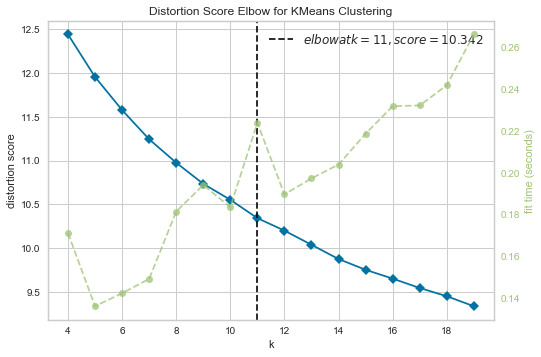

In [208]:
df_freq_clustering = df_freq.drop('City', 1)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,20))
visualizer.fit(df_freq_clustering)        
visualizer.show()        

Unfortunately, k = 11 is not the clearest elbow point, but it will do.

In [236]:
kclusters = 11
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_freq_clustering)

We will add these labels, and the most common restaurants to our original city dataframe. We will also remove some uneeded colums.

In [239]:
df_city_common.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df_cities.join(df_city_common.set_index('City'), on='City')

df_merged.drop(["Rank", "Growth From 2000 to 2013"], 1, inplace=True)

df_merged.head() 

City           State  Population   Latitude   Longitude  \
0  Marysville      Washington       63269  48.051764 -122.177082   
1      Perris      California       72326  33.782519 -117.228648   
2   Cleveland            Ohio      390113  41.499320  -81.694361   
3   Worcester   Massachusetts      182544  42.262593  -71.802293   
4    Columbia  South Carolina      133358  34.000710  -81.034814   

   Cluster Labels 1st Most Common Restaurant 2nd Most Common Restaurant  \
0               0         Mexican Restaurant                Pizza Place   
1               8         Mexican Restaurant               Burger Joint   
2               1        American Restaurant             Sandwich Place   
3               7        American Restaurant                Pizza Place   
4               1        American Restaurant                Pizza Place   

  3rd Most Common Restaurant 4th Most Common Restaurant  ...  \
0               Burger Joint             Sandwich Place  ...   
1             Sandwich Place       Fast Food Restaurant  ...   
2       Fast Food Restaurant                Pizza Place  ...   
3                     Bakery         Mexican Restaurant  ...   
4         Mexican Restaurant             Sandwich Place  ...   

  11th Most Common Restaurant 12th Most Common Restaurant  \
0            Sushi Restaurant            Asian Restaurant   
1            Asian Restaurant                   BBQ Joint   
2                       Diner                   Gastropub   
3                Burger Joint                       Diner   
4               Deli / Bodega          Seafood Restaurant   

  13th Most Common Restaurant 14th Most Common Restaurant  \
0                       Diner       Vietnamese Restaurant   
1             Thai Restaurant                      Bakery   
2                      Bakery          Chinese Restaurant   
3   Middle Eastern Restaurant        Fast Food Restaurant   
4                        Café          Italian Restaurant   

  15th Most Common Restaurant      16th Most Common Restaurant  \
0          Chinese Restaurant                   Breakfast Spot   
1                 Wings Joint               Seafood Restaurant   
2                   BBQ Joint                  Thai Restaurant   
3                  Steakhouse                    Deli / Bodega   
4                  Donut Shop  Southern / Soul Food Restaurant   

  17th Most Common Restaurant 18th Most Common Restaurant  \
0        Fast Food Restaurant                  Steakhouse   
1                        Café          Chinese Restaurant   
2            Sushi Restaurant     New American Restaurant   
3          Seafood Restaurant                  Restaurant   
4                  Restaurant              Breakfast Spot   

  19th Most Common Restaurant 20th Most Common Restaurant  
0                  Taco Place                   BBQ Joint  
1               Hot Dog Joint         Hawaiian Restaurant  
2                  Taco Place   Middle Eastern Restaurant  
3            Sushi Restaurant       Vietnamese Restaurant  
4                   Gastropub                 Wings Joint  

[5 rows x 26 columns]

We can visualize these clusters on a map.

In [240]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['City'],df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [243]:
df_cluster_sizes = df_merged.groupby("Cluster Labels").count()[['City']]
df_cluster_sizes.columns = ["Number of Cities"]
df_cluster_sizes

Number of Cities
Cluster Labels                  
0                             84
1                            128
2                             28
3                            156
4                             15
5                            156
6                             77
7                            112
8                             78
9                             79
10                            87

Let us examine each cluster.

**Cluster 1**

In [265]:
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City           State  Cluster Labels 1st Most Common Restaurant  \
0    Marysville      Washington               0         Mexican Restaurant   
82         Brea      California               0               Burger Joint   
94  Chapel Hill  North Carolina               0             Sandwich Place   
96     Calexico      California               0                 Taco Place   
98     Missoula         Montana               0             Sandwich Place   

   2nd Most Common Restaurant 3rd Most Common Restaurant  \
0                 Pizza Place               Burger Joint   
82                Pizza Place         Mexican Restaurant   
94        American Restaurant                Pizza Place   
96         Mexican Restaurant       Fast Food Restaurant   
98                Pizza Place                     Bakery   

   4th Most Common Restaurant 5th Most Common Restaurant  \
0              Sandwich Place        American Restaurant   
82             Sandwich Place        American Restaurant   
94         Mexican Restaurant               Burger Joint   
96         Seafood Restaurant               Burger Joint   
98         Mexican Restaurant                       Café   

   6th Most Common Restaurant       7th Most Common Restaurant  ...  \
0          Seafood Restaurant                  Thai Restaurant  ...   
82                 Steakhouse                Korean Restaurant  ...   
94             Breakfast Spot  Southern / Soul Food Restaurant  ...   
96         Chinese Restaurant                      Pizza Place  ...   
98        American Restaurant                       Restaurant  ...   

   11th Most Common Restaurant 12th Most Common Restaurant  \
0             Sushi Restaurant            Asian Restaurant   
82                   BBQ Joint        Fast Food Restaurant   
94            Asian Restaurant          Italian Restaurant   
96         Japanese Restaurant                      Bakery   
98            Asian Restaurant                       Diner   

   13th Most Common Restaurant 14th Most Common Restaurant  \
0                        Diner       Vietnamese Restaurant   
82            Sushi Restaurant    Mediterranean Restaurant   
94                  Steakhouse                        Café   
96                 Snack Place                   BBQ Joint   
98               Burrito Place        Brazilian Restaurant   

   15th Most Common Restaurant 16th Most Common Restaurant  \
0           Chinese Restaurant              Breakfast Spot   
82               Hot Dog Joint                  Food Court   
94          Seafood Restaurant                  Taco Place   
96            Asian Restaurant        Brazilian Restaurant   
98            Sushi Restaurant                   Gastropub   

   17th Most Common Restaurant 18th Most Common Restaurant  \
0         Fast Food Restaurant                  Steakhouse   
82   Cajun / Creole Restaurant                 Salad Place   
94                       Diner               Deli / Bodega   
96                  Restaurant                  Steakhouse   
98                 Snack Place                   BBQ Joint   

   19th Most Common Restaurant    20th Most Common Restaurant  
0                   Taco Place                      BBQ Joint  
82            Greek Restaurant                     Restaurant  
94                 Wings Joint  Vegetarian / Vegan Restaurant  
96                       Diner                 Sandwich Place  
98           French Restaurant                   Burger Joint  

[5 rows x 23 columns]

**Cluster 2**

In [266]:
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City           State  Cluster Labels 1st Most Common Restaurant  \
2       Cleveland            Ohio               1        American Restaurant   
4        Columbia  South Carolina               1        American Restaurant   
15          Salem   Massachusetts               1        American Restaurant   
17       Leesburg        Virginia               1        American Restaurant   
21  Overland Park          Kansas               1        American Restaurant   

   2nd Most Common Restaurant 3rd Most Common Restaurant  \
2              Sandwich Place       Fast Food Restaurant   
4                 Pizza Place         Mexican Restaurant   
15                Pizza Place         Mexican Restaurant   
17               Burger Joint                Pizza Place   
21                Pizza Place                     Bakery   

   4th Most Common Restaurant 5th Most Common Restaurant  \
2                 Pizza Place         Mexican Restaurant   
4              Sandwich Place               Burger Joint   
15             Sandwich Place         Italian Restaurant   
17             Sandwich Place         Seafood Restaurant   
21                  BBQ Joint             Sandwich Place   

   6th Most Common Restaurant 7th Most Common Restaurant  ...  \
2               Deli / Bodega                 Steakhouse  ...   
4                      Bakery                  BBQ Joint  ...   
15                     Bakery               Burger Joint  ...   
17         Mexican Restaurant                       Café  ...   
21         Italian Restaurant         Mexican Restaurant  ...   

   11th Most Common Restaurant 12th Most Common Restaurant  \
2                        Diner                   Gastropub   
4                Deli / Bodega          Seafood Restaurant   
15            Sushi Restaurant             Thai Restaurant   
17          Italian Restaurant                   BBQ Joint   
21          Seafood Restaurant                Burger Joint   

   13th Most Common Restaurant 14th Most Common Restaurant  \
2                       Bakery          Chinese Restaurant   
4                         Café          Italian Restaurant   
15              Breakfast Spot          Chinese Restaurant   
17             Thai Restaurant           Indian Restaurant   
21             Thai Restaurant        Fast Food Restaurant   

   15th Most Common Restaurant      16th Most Common Restaurant  \
2                    BBQ Joint                  Thai Restaurant   
4                   Donut Shop  Southern / Soul Food Restaurant   
15                  Steakhouse              Japanese Restaurant   
17    Mediterranean Restaurant                Korean Restaurant   
21                  Steakhouse                Korean Restaurant   

   17th Most Common Restaurant 18th Most Common Restaurant  \
2             Sushi Restaurant     New American Restaurant   
4                   Restaurant              Breakfast Spot   
15                  Bagel Shop           Indian Restaurant   
17                 Wings Joint   Latin American Restaurant   
21   Middle Eastern Restaurant                  Restaurant   

   19th Most Common Restaurant 20th Most Common Restaurant  
2                   Taco Place   Middle Eastern Restaurant  
4                    Gastropub                 Wings Joint  
15            Asian Restaurant        Fast Food Restaurant  
17          Chinese Restaurant            Kebab Restaurant  
21                  Food Court                        Café  

[5 rows x 23 columns]

**Cluster 3**

In [267]:
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City        State  Cluster Labels 1st Most Common Restaurant  \
5     Waterbury  Connecticut               2                Pizza Place   
88      Trenton   New Jersey               2         Italian Restaurant   
198     Norwich  Connecticut               2                Pizza Place   
225     Yonkers     New York               2                Pizza Place   
248  Youngstown         Ohio               2         Italian Restaurant   

    2nd Most Common Restaurant 3rd Most Common Restaurant  \
5           Italian Restaurant        American Restaurant   
88                 Pizza Place        American Restaurant   
198         Italian Restaurant        American Restaurant   
225         Italian Restaurant                     Bakery   
248        American Restaurant                Pizza Place   

    4th Most Common Restaurant 5th Most Common Restaurant  \
5                Deli / Bodega       Fast Food Restaurant   
88                      Bakery                       Café   
198             Breakfast Spot                 Steakhouse   
225         Mexican Restaurant        American Restaurant   
248             Sandwich Place         Mexican Restaurant   

    6th Most Common Restaurant 7th Most Common Restaurant  ...  \
5               Sandwich Place                 Bagel Shop  ...   
88        Fast Food Restaurant                 Restaurant  ...   
198                     Bakery               Burger Joint  ...   
225              Deli / Bodega        Japanese Restaurant  ...   
248                     Bakery                Wings Joint  ...   

    11th Most Common Restaurant 12th Most Common Restaurant  \
5                         Diner          Chinese Restaurant   
88                Deli / Bodega                       Diner   
198          Mexican Restaurant            Asian Restaurant   
225           Korean Restaurant        Caribbean Restaurant   
248                  Donut Shop                  Restaurant   

    13th Most Common Restaurant 14th Most Common Restaurant  \
5                     BBQ Joint              Breakfast Spot   
88            Indian Restaurant          Mexican Restaurant   
198          Seafood Restaurant                 Wings Joint   
225                Burger Joint                   BBQ Joint   
248                   Gastropub   Middle Eastern Restaurant   

    15th Most Common Restaurant 16th Most Common Restaurant  \
5                    Steakhouse                   Gastropub   
88               Breakfast Spot            Sushi Restaurant   
198                       Diner                  Restaurant   
225               Hot Dog Joint            Greek Restaurant   
248                       Diner          Seafood Restaurant   

    17th Most Common Restaurant  18th Most Common Restaurant  \
5                    Donut Shop          Japanese Restaurant   
88         Caribbean Restaurant  Eastern European Restaurant   
198     New American Restaurant                Deli / Bodega   
225                       Diner     Mediterranean Restaurant   
248               Hot Dog Joint           Chinese Restaurant   

       19th Most Common Restaurant 20th Most Common Restaurant  
5          New American Restaurant                        Café  
88         New American Restaurant          Chinese Restaurant  
198           Fast Food Restaurant           Indian Restaurant  
225                 Sandwich Place             Soba Restaurant  
248  Vegetarian / Vegan Restaurant              Breakfast Spot  

[5 rows x 23 columns]

**Cluster 4**

In [268]:
df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City       State  Cluster Labels 1st Most Common Restaurant  \
8    Lafayette   Louisiana               3                Pizza Place   
9   Boise City       Idaho               3                Pizza Place   
10     Elkhart     Indiana               3         Mexican Restaurant   
11  Buena Park  California               3                Pizza Place   
12    Marietta     Georgia               3                Pizza Place   

   2nd Most Common Restaurant 3rd Most Common Restaurant  \
8   Cajun / Creole Restaurant        American Restaurant   
9          Mexican Restaurant               Burger Joint   
10        American Restaurant         Italian Restaurant   
11        American Restaurant               Burger Joint   
12        American Restaurant                     Bakery   

   4th Most Common Restaurant 5th Most Common Restaurant  \
8              Sandwich Place         Mexican Restaurant   
9              Breakfast Spot         Italian Restaurant   
10             Breakfast Spot                Pizza Place   
11         Mexican Restaurant                     Bakery   
12             Sandwich Place               Burger Joint   

   6th Most Common Restaurant 7th Most Common Restaurant  ...  \
8                Burger Joint       Fast Food Restaurant  ...   
9         American Restaurant                 Steakhouse  ...   
10             Sandwich Place                     Bakery  ...   
11                 Steakhouse             Sandwich Place  ...   
12         Seafood Restaurant           Sushi Restaurant  ...   

   11th Most Common Restaurant 12th Most Common Restaurant  \
8                         Café              Breakfast Spot   
9         Fast Food Restaurant            Greek Restaurant   
10        Fast Food Restaurant          Seafood Restaurant   
11               Hot Dog Joint    Mediterranean Restaurant   
12             Thai Restaurant                        Café   

   13th Most Common Restaurant 14th Most Common Restaurant  \
8              Thai Restaurant          Chinese Restaurant   
9                       Bakery            Sushi Restaurant   
10                        Café                       Diner   
11              Breakfast Spot            Sushi Restaurant   
12        Fast Food Restaurant                  Donut Shop   

   15th Most Common Restaurant 16th Most Common Restaurant  \
8                        Diner           Indian Restaurant   
9                    BBQ Joint          Chinese Restaurant   
10                  Restaurant               Deli / Bodega   
11   Cajun / Creole Restaurant          Italian Restaurant   
12     New American Restaurant                   BBQ Joint   

   17th Most Common Restaurant 18th Most Common Restaurant  \
8             Greek Restaurant            Sushi Restaurant   
9                         Café   Latin American Restaurant   
10                 Wings Joint                  Donut Shop   
11           Korean Restaurant         Japanese Restaurant   
12        Caribbean Restaurant                  Restaurant   

        19th Most Common Restaurant 20th Most Common Restaurant  
8                        Steakhouse                  Restaurant  
9              Caribbean Restaurant           Korean Restaurant  
10                     Noodle House    Mediterranean Restaurant  
11                             Café                  Food Court  
12  Southern / Soul Food Restaurant            Cuban Restaurant  

[5 rows x 23 columns]

**Cluster 5**

In [269]:
df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City           State  Cluster Labels 1st Most Common Restaurant  \
73     Texarkana           Texas               4       Fast Food Restaurant   
81       Buckeye         Arizona               4       Fast Food Restaurant   
107  Porterville      California               4       Fast Food Restaurant   
176     Maricopa         Arizona               4       Fast Food Restaurant   
240  Rocky Mount  North Carolina               4       Fast Food Restaurant   

    2nd Most Common Restaurant 3rd Most Common Restaurant  \
73         American Restaurant             Sandwich Place   
81                 Pizza Place         Mexican Restaurant   
107                Pizza Place         Mexican Restaurant   
176                Pizza Place        American Restaurant   
240                Pizza Place             Sandwich Place   

    4th Most Common Restaurant 5th Most Common Restaurant  \
73                Burger Joint         Mexican Restaurant   
81              Sandwich Place        American Restaurant   
107             Sandwich Place             Breakfast Spot   
176             Sandwich Place         Mexican Restaurant   
240                  BBQ Joint             Breakfast Spot   

    6th Most Common Restaurant 7th Most Common Restaurant  ...  \
73         Fried Chicken Joint                Pizza Place  ...   
81                 Wings Joint         Italian Restaurant  ...   
107        American Restaurant         Chinese Restaurant  ...   
176                 Donut Shop             Breakfast Spot  ...   
240                      Diner                       Food  ...   

    11th Most Common Restaurant 12th Most Common Restaurant  \
73                Deli / Bodega                 Wings Joint   
81      New American Restaurant                        Café   
107          Italian Restaurant                        Food   
176                   BBQ Joint                        Café   
240          Chinese Restaurant                Burger Joint   

    13th Most Common Restaurant 14th Most Common Restaurant  \
73           Italian Restaurant          Chinese Restaurant   
81                   Food Truck                  Truck Stop   
107                  Donut Shop                  Steakhouse   
176          Chinese Restaurant     New American Restaurant   
240         Fried Chicken Joint                        Café   

    15th Most Common Restaurant 16th Most Common Restaurant  \
73                    BBQ Joint                  Food Stand   
81                 Burger Joint          Chinese Restaurant   
107                       Diner     Comfort Food Restaurant   
176                Burger Joint            Sushi Restaurant   
240         Japanese Restaurant         American Restaurant   

    17th Most Common Restaurant 18th Most Common Restaurant  \
73                       Buffet                  Restaurant   
81               Breakfast Spot                      Bistro   
107          Seafood Restaurant                 Wings Joint   
176                       Diner          Falafel Restaurant   
240                  Steakhouse                   Gastropub   

    19th Most Common Restaurant 20th Most Common Restaurant  
73                   Donut Shop            Sushi Restaurant  
81                   Bagel Shop        Ethiopian Restaurant  
107                  Restaurant                   BBQ Joint  
176           Fish & Chips Shop        Ethiopian Restaurant  
240                      Buffet               Deli / Bodega  

[5 rows x 23 columns]

**Cluster 6**

In [270]:
df_merged.loc[df_merged['Cluster Labels'] == 5, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City           State  Cluster Labels 1st Most Common Restaurant  \
19  Westminster      California               5        American Restaurant   
25  Kansas City        Missouri               5        American Restaurant   
32   Greenville  North Carolina               5        American Restaurant   
43       Apopka         Florida               5         Mexican Restaurant   
48       Rogers        Arkansas               5        American Restaurant   

   2nd Most Common Restaurant 3rd Most Common Restaurant  \
19         Mexican Restaurant                Pizza Place   
25         Mexican Restaurant                Pizza Place   
32             Sandwich Place         Mexican Restaurant   
43        American Restaurant                  BBQ Joint   
48         Mexican Restaurant               Burger Joint   

   4th Most Common Restaurant 5th Most Common Restaurant  \
19         Italian Restaurant         Seafood Restaurant   
25         Italian Restaurant                  BBQ Joint   
32       Fast Food Restaurant                Pizza Place   
43             Sandwich Place                Pizza Place   
48                Pizza Place             Sandwich Place   

   6th Most Common Restaurant 7th Most Common Restaurant  ...  \
19               Burger Joint    New American Restaurant  ...   
25           Sushi Restaurant             Breakfast Spot  ...   
32               Burger Joint                 Steakhouse  ...   
43              Deli / Bodega       Fast Food Restaurant  ...   
48       Fast Food Restaurant                 Steakhouse  ...   

   11th Most Common Restaurant      12th Most Common Restaurant  \
19                      Bakery                   Sandwich Place   
25                Burger Joint                French Restaurant   
32                        Café  Southern / Soul Food Restaurant   
43                  Steakhouse          New American Restaurant   
48         Fried Chicken Joint         Mediterranean Restaurant   

   13th Most Common Restaurant 14th Most Common Restaurant  \
19    Mediterranean Restaurant                  Restaurant   
25                   Gastropub                  Restaurant   
32                      Bakery               Deli / Bodega   
43            Sushi Restaurant         Japanese Restaurant   
48            Asian Restaurant                  Bagel Shop   

   15th Most Common Restaurant 16th Most Common Restaurant  \
19                  Steakhouse        Fast Food Restaurant   
25                  Steakhouse                      Bakery   
32            Sushi Restaurant    Mediterranean Restaurant   
43            Cuban Restaurant                Burger Joint   
48          Chinese Restaurant       Vietnamese Restaurant   

   17th Most Common Restaurant 18th Most Common Restaurant  \
19               Hot Dog Joint            Tapas Restaurant   
25    Mediterranean Restaurant                        Café   
32              Breakfast Spot          Seafood Restaurant   
43          Chinese Restaurant                      Bakery   
48                  Restaurant          Italian Restaurant   

   19th Most Common Restaurant 20th Most Common Restaurant  
19                        Café                  Taco Place  
25            Tapas Restaurant             Thai Restaurant  
32         Japanese Restaurant           Indian Restaurant  
43                  Restaurant            Tapas Restaurant  
48                   BBQ Joint                  Food Truck  

[5 rows x 23 columns]

**Cluster 7**

In [271]:
df_merged.loc[df_merged['Cluster Labels'] == 6, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City       State  Cluster Labels 1st Most Common Restaurant  \
18        Doral     Florida               6         Italian Restaurant   
49  New Orleans   Louisiana               6  Cajun / Creole Restaurant   
53     Portland      Oregon               6                Pizza Place   
55       Burien  Washington               6         Italian Restaurant   
74     Portland       Maine               6                Pizza Place   

   2nd Most Common Restaurant 3rd Most Common Restaurant  \
18                Pizza Place                 Steakhouse   
49             Sandwich Place         Seafood Restaurant   
53         Seafood Restaurant                     Bakery   
55                Pizza Place      Vietnamese Restaurant   
74         Seafood Restaurant                     Bakery   

   4th Most Common Restaurant 5th Most Common Restaurant  \
18           Cuban Restaurant        American Restaurant   
49                       Café          French Restaurant   
53         Italian Restaurant                       Café   
55           Sushi Restaurant                     Bakery   
74         Italian Restaurant                       Café   

   6th Most Common Restaurant 7th Most Common Restaurant  ...  \
18        Japanese Restaurant                     Bakery  ...   
49         Italian Restaurant        American Restaurant  ...   
53             Sandwich Place               Burger Joint  ...   
55               Burger Joint         Mexican Restaurant  ...   
74             Sandwich Place               Burger Joint  ...   

        11th Most Common Restaurant 12th Most Common Restaurant  \
18                             Café        Fast Food Restaurant   
49  Southern / Soul Food Restaurant     New American Restaurant   
53                 Sushi Restaurant              Breakfast Spot   
55                   Sandwich Place                  Poke Place   
74                 Sushi Restaurant              Breakfast Spot   

   13th Most Common Restaurant 14th Most Common Restaurant  \
18                Burger Joint      Argentinian Restaurant   
49       Vietnamese Restaurant               Deli / Bodega   
53             Thai Restaurant          Mexican Restaurant   
55         American Restaurant                  Steakhouse   
74             Thai Restaurant          Mexican Restaurant   

   15th Most Common Restaurant 16th Most Common Restaurant  \
18          Spanish Restaurant              Sandwich Place   
49                  Steakhouse        Caribbean Restaurant   
53     New American Restaurant                  Steakhouse   
55                       Diner                  Donut Shop   
74     New American Restaurant                  Steakhouse   

   17th Most Common Restaurant 18th Most Common Restaurant  \
18          Seafood Restaurant                   Gastropub   
49                Burger Joint                      Bakery   
53               Deli / Bodega                       Diner   
55     New American Restaurant         Hawaiian Restaurant   
74               Deli / Bodega                       Diner   

   19th Most Common Restaurant 20th Most Common Restaurant  
18   South American Restaurant   Latin American Restaurant  
49            Tapas Restaurant                   Irish Pub  
53                   BBQ Joint                  Food Truck  
55         Dumpling Restaurant            Asian Restaurant  
74                   BBQ Joint                  Food Truck  

[5 rows x 23 columns]

**Cluster 8**

In [272]:
df_merged.loc[df_merged['Cluster Labels'] == 7, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City          State  Cluster Labels 1st Most Common Restaurant  \
3         Worcester  Massachusetts               7        American Restaurant   
6             Eagan      Minnesota               7                Pizza Place   
7        Southfield       Michigan               7                Pizza Place   
14  West Palm Beach        Florida               7        American Restaurant   
29     Gaithersburg       Maryland               7                Pizza Place   

   2nd Most Common Restaurant 3rd Most Common Restaurant  \
3                 Pizza Place                     Bakery   
6         American Restaurant                     Bakery   
7         American Restaurant         Italian Restaurant   
14         Italian Restaurant                      Diner   
29        American Restaurant           Sushi Restaurant   

   4th Most Common Restaurant 5th Most Common Restaurant  \
3          Mexican Restaurant             Breakfast Spot   
6          Italian Restaurant               Burger Joint   
7            Sushi Restaurant         Seafood Restaurant   
14                Pizza Place           Asian Restaurant   
29         Mexican Restaurant            Thai Restaurant   

   6th Most Common Restaurant 7th Most Common Restaurant  ...  \
3              Sandwich Place                 Donut Shop  ...   
6          Mexican Restaurant             Breakfast Spot  ...   
7              Breakfast Spot             Sandwich Place  ...   
14                       Café             Sandwich Place  ...   
29                 Donut Shop         Chinese Restaurant  ...   

   11th Most Common Restaurant 12th Most Common Restaurant  \
3                 Burger Joint                       Diner   
6             Asian Restaurant                       Diner   
7                   Restaurant                  Donut Shop   
14              Breakfast Spot          Seafood Restaurant   
29              Sandwich Place        Fast Food Restaurant   

   13th Most Common Restaurant      14th Most Common Restaurant  \
3    Middle Eastern Restaurant             Fast Food Restaurant   
6               Sandwich Place  Southern / Soul Food Restaurant   
7                    Gastropub                 Greek Restaurant   
14           French Restaurant               Mexican Restaurant   
29            Asian Restaurant              Peruvian Restaurant   

   15th Most Common Restaurant 16th Most Common Restaurant  \
3                   Steakhouse               Deli / Bodega   
6           Chinese Restaurant         Fried Chicken Joint   
7                    BBQ Joint               Deli / Bodega   
14             Thai Restaurant                      Bakery   
29    Mediterranean Restaurant               Deli / Bodega   

   17th Most Common Restaurant 18th Most Common Restaurant  \
3           Seafood Restaurant                  Restaurant   
6           Seafood Restaurant           Afghan Restaurant   
7           Chinese Restaurant         Fried Chicken Joint   
14            Sushi Restaurant        Fast Food Restaurant   
29              Breakfast Spot                Burger Joint   

   19th Most Common Restaurant 20th Most Common Restaurant  
3             Sushi Restaurant       Vietnamese Restaurant  
6                Burrito Place   Middle Eastern Restaurant  
7      New American Restaurant    Mediterranean Restaurant  
14                   Gastropub         Japanese Restaurant  
29                  Taco Place                  Steakhouse  

[5 rows x 23 columns]

**Cluster 9**

In [273]:
df_merged.loc[df_merged['Cluster Labels'] == 8, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City       State  Cluster Labels 1st Most Common Restaurant  \
1          Perris  California               8         Mexican Restaurant   
20        Lubbock       Texas               8         Mexican Restaurant   
28          Chino  California               8         Mexican Restaurant   
64  Moreno Valley  California               8         Mexican Restaurant   
80      Pittsburg  California               8         Mexican Restaurant   

   2nd Most Common Restaurant 3rd Most Common Restaurant  \
1                Burger Joint             Sandwich Place   
20               Burger Joint                 Steakhouse   
28               Burger Joint        American Restaurant   
64               Burger Joint       Fast Food Restaurant   
80                Pizza Place               Burger Joint   

   4th Most Common Restaurant 5th Most Common Restaurant  \
1        Fast Food Restaurant        American Restaurant   
20        American Restaurant                Pizza Place   
28                Pizza Place             Sandwich Place   
64            Thai Restaurant         Italian Restaurant   
80        American Restaurant             Sandwich Place   

   6th Most Common Restaurant 7th Most Common Restaurant  ...  \
1                 Pizza Place             Breakfast Spot  ...   
20        Fried Chicken Joint             Sandwich Place  ...   
28       Fast Food Restaurant                     Bakery  ...   
64        American Restaurant             Sandwich Place  ...   
80         Chinese Restaurant                     Bakery  ...   

   11th Most Common Restaurant 12th Most Common Restaurant  \
1             Asian Restaurant                   BBQ Joint   
20          Italian Restaurant             Thai Restaurant   
28    Mediterranean Restaurant          Chinese Restaurant   
64                   Gastropub                  Steakhouse   
80       Vietnamese Restaurant         Fried Chicken Joint   

   13th Most Common Restaurant 14th Most Common Restaurant  \
1              Thai Restaurant                      Bakery   
20                      Bakery                  Taco Place   
28         Japanese Restaurant              Breakfast Spot   
64               Deli / Bodega          Seafood Restaurant   
80            Sushi Restaurant           Indian Restaurant   

   15th Most Common Restaurant 16th Most Common Restaurant  \
1                  Wings Joint          Seafood Restaurant   
20            Asian Restaurant              Breakfast Spot   
28                  Steakhouse            Sushi Restaurant   
64                        Café               Hot Dog Joint   
80                   Gastropub                  Taco Place   

   17th Most Common Restaurant 18th Most Common Restaurant  \
1                         Café          Chinese Restaurant   
20                        Café                  Donut Shop   
28                  Restaurant               Deli / Bodega   
64           Indian Restaurant            Asian Restaurant   
80                  Bagel Shop                   BBQ Joint   

   19th Most Common Restaurant 20th Most Common Restaurant  
1                Hot Dog Joint         Hawaiian Restaurant  
20                  Restaurant           French Restaurant  
28             Thai Restaurant                   BBQ Joint  
64          Tex-Mex Restaurant                  Food Truck  
80            Asian Restaurant                  Food Truck  

[5 rows x 23 columns]

**Cluster 10**

In [274]:
df_merged.loc[df_merged['Cluster Labels'] == 9, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City           State  Cluster Labels  \
22          Jackson     Mississippi               9   
23         Gastonia  North Carolina               9   
24    Daytona Beach         Florida               9   
30  Fountain Valley      California               9   
37       Fall River   Massachusetts               9   

   1st Most Common Restaurant 2nd Most Common Restaurant  \
22        American Restaurant       Fast Food Restaurant   
23                Pizza Place         Seafood Restaurant   
24         Seafood Restaurant        American Restaurant   
30         Seafood Restaurant        American Restaurant   
37        American Restaurant         Seafood Restaurant   

   3rd Most Common Restaurant       4th Most Common Restaurant  \
22               Burger Joint  Southern / Soul Food Restaurant   
23        American Restaurant               Mexican Restaurant   
24             Breakfast Spot               Italian Restaurant   
30         Mexican Restaurant                           Bakery   
37             Breakfast Spot                      Pizza Place   

   5th Most Common Restaurant 6th Most Common Restaurant  \
22                  BBQ Joint             Sandwich Place   
23                  BBQ Joint       Fast Food Restaurant   
24                Pizza Place         Mexican Restaurant   
30         Italian Restaurant             Sandwich Place   
37                 Restaurant                       Café   

   7th Most Common Restaurant  ...    11th Most Common Restaurant  \
22        Japanese Restaurant  ...             Seafood Restaurant   
23             Sandwich Place  ...             Italian Restaurant   
24               Burger Joint  ...           Fast Food Restaurant   
30               Burger Joint  ...  Vegetarian / Vegan Restaurant   
37                     Bakery  ...          Portuguese Restaurant   

   12th Most Common Restaurant 13th Most Common Restaurant  \
22               Deli / Bodega                        Café   
23                Burger Joint         Japanese Restaurant   
24             Thai Restaurant                      Bakery   
30            Tapas Restaurant                  Taco Place   
37                   Gastropub                  Steakhouse   

        14th Most Common Restaurant  15th Most Common Restaurant  \
22               Mexican Restaurant             Sushi Restaurant   
23  Southern / Soul Food Restaurant                   Donut Shop   
24                 Asian Restaurant                  Snack Place   
30                      Pizza Place             Sushi Restaurant   
37                       Donut Shop  Eastern European Restaurant   

   16th Most Common Restaurant 17th Most Common Restaurant  \
22          Chinese Restaurant            Greek Restaurant   
23                   Gastropub                  Restaurant   
24                   BBQ Joint    Mediterranean Restaurant   
30               Deli / Bodega              Breakfast Spot   
37          Mexican Restaurant        Fast Food Restaurant   

   18th Most Common Restaurant 19th Most Common Restaurant  \
22         Fried Chicken Joint                      Bakery   
23          Chinese Restaurant              Breakfast Spot   
24   South American Restaurant          Chinese Restaurant   
30       Vietnamese Restaurant                  Poke Place   
37                Burger Joint    Mediterranean Restaurant   

   20th Most Common Restaurant  
22                  Restaurant  
23            Sushi Restaurant  
24        Caribbean Restaurant  
30                  Restaurant  
37                        Food  

[5 rows x 23 columns]

**Cluster 11**

In [275]:
df_merged.loc[df_merged['Cluster Labels'] == 10, df_merged.columns[[0, 1] + list(range(5, df_merged.shape[1]))]].head()

City       State  Cluster Labels 1st Most Common Restaurant  \
38            Tulare  California              10                Pizza Place   
52          Caldwell       Idaho              10                Pizza Place   
67  Lake Havasu City     Arizona              10                Pizza Place   
77         El Centro  California              10       Fast Food Restaurant   
79             Flint    Michigan              10         Mexican Restaurant   

   2nd Most Common Restaurant 3rd Most Common Restaurant  \
38       Fast Food Restaurant         Mexican Restaurant   
52         Mexican Restaurant       Fast Food Restaurant   
67             Sandwich Place         Mexican Restaurant   
77         Mexican Restaurant                 Taco Place   
79             Sandwich Place                Pizza Place   

   4th Most Common Restaurant 5th Most Common Restaurant  \
38             Sandwich Place        American Restaurant   
52               Burger Joint             Sandwich Place   
67        American Restaurant       Fast Food Restaurant   
77         Chinese Restaurant             Breakfast Spot   
79         Italian Restaurant                      Diner   

   6th Most Common Restaurant 7th Most Common Restaurant  ...  \
38               Burger Joint                       Café  ...   
52        American Restaurant         Chinese Restaurant  ...   
67         Italian Restaurant                      Diner  ...   
77               Burger Joint                Pizza Place  ...   
79               Burger Joint         Chinese Restaurant  ...   

   11th Most Common Restaurant 12th Most Common Restaurant  \
38            Sushi Restaurant         Japanese Restaurant   
52                        Café                  Taco Place   
67          Chinese Restaurant                  Steakhouse   
77              Sandwich Place                 Salad Place   
79        Fast Food Restaurant                  Steakhouse   

   13th Most Common Restaurant 14th Most Common Restaurant  \
38              Breakfast Spot       Vietnamese Restaurant   
52             Thai Restaurant          Italian Restaurant   
67         Fried Chicken Joint     Comfort Food Restaurant   
77                   BBQ Joint   Middle Eastern Restaurant   
79                  Restaurant         Japanese Restaurant   

   15th Most Common Restaurant 16th Most Common Restaurant  \
38    Mediterranean Restaurant                        Food   
52                  Restaurant                      Buffet   
67               Deli / Bodega                      Buffet   
77          Italian Restaurant            Asian Restaurant   
79                      Bakery             Thai Restaurant   

   17th Most Common Restaurant      18th Most Common Restaurant  \
38          Chinese Restaurant               Seafood Restaurant   
52     New American Restaurant                     Noodle House   
67              Breakfast Spot                           Bistro   
77         Japanese Restaurant  Southern / Soul Food Restaurant   
79                  Taco Place                       Donut Shop   

   19th Most Common Restaurant    20th Most Common Restaurant  
38                  Donut Shop  Vegetarian / Vegan Restaurant  
52                       Diner                    Wings Joint  
67         Japanese Restaurant                         Bakery  
77                        Café                   Noodle House  
79          Seafood Restaurant              Indian Restaurant  

[5 rows x 23 columns]

Suppose we own a Korean Restaurant. We want to find a cluster where Korean Resturants are popular.

In [281]:
df_freq.insert(0, 'Cluster Labels', kmeans.labels_)
df_freq

Cluster Labels        City  Afghan Restaurant  African Restaurant  \
0                10     Abilene                0.0                 0.0   
1                 3     Addison                0.0                 0.0   
2                 5       Akron                0.0                 0.0   
3                 6     Alameda                0.0                 0.0   
4                 1      Albany                0.0                 0.0   
..              ...         ...                ...                 ...   
920               2        York                0.0                 0.0   
921               2  Youngstown                0.0                 0.0   
922              10   Yuba City                0.0                 0.0   
923               8     Yucaipa                0.0                 0.0   
924               8        Yuma                0.0                 0.0   

     American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0               0.109890               0.0                     0.0   
1               0.070000               0.0                     0.0   
2               0.140000               0.0                     0.0   
3               0.020000               0.0                     0.0   
4               0.092593               0.0                     0.0   
..                   ...               ...                     ...   
920             0.100000               0.0                     0.0   
921             0.130000               0.0                     0.0   
922             0.030000               0.0                     0.0   
923             0.080000               0.0                     0.0   
924             0.090000               0.0                     0.0   

     Asian Restaurant  Australian Restaurant  Austrian Restaurant  ...  \
0             0.00000                    0.0                  0.0  ...   
1             0.00000                    0.0                  0.0  ...   
2             0.00000                    0.0                  0.0  ...   
3             0.00000                    0.0                  0.0  ...   
4             0.02963                    0.0                  0.0  ...   
..                ...                    ...                  ...  ...   
920           0.01000                    0.0                  0.0  ...   
921           0.00000                    0.0                  0.0  ...   
922           0.02000                    0.0                  0.0  ...   
923           0.03000                    0.0                  0.0  ...   
924           0.02000                    0.0                  0.0  ...   

     Theme Restaurant  Tibetan Restaurant  Trattoria/Osteria  Truck Stop  \
0                 0.0                0.00                0.0         0.0   
1                 0.0                0.00                0.0         0.0   
2                 0.0                0.00                0.0         0.0   
3                 0.0                0.01                0.0         0.0   
4                 0.0                0.00                0.0         0.0   
..                ...                 ...                ...         ...   
920               0.0                0.00                0.0         0.0   
921               0.0                0.00                0.0         0.0   
922               0.0                0.00                0.0         0.0   
923               0.0                0.00                0.0         0.0   
924               0.0                0.00                0.0         0.0   

     Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                   0.0              0.0                       0.000000   
1                   0.0              0.0                       0.000000   
2                   0.0              0.0                       0.010000   
3                   0.0              0.0                       0.000000   
4                   0.0              0.0                       0.011111   
..                  ...

In [284]:
df_clusterfreq = df_freq.groupby("Cluster Labels").mean()
df_clusterfreq 

Afghan Restaurant  African Restaurant  American Restaurant  \
Cluster Labels                                                               
0                        0.001456            0.000000             0.045509   
1                        0.000102            0.000096             0.132562   
2                        0.000000            0.000000             0.070184   
3                        0.000143            0.000786             0.070068   
4                        0.000000            0.000000             0.067859   
5                        0.000000            0.000000             0.090736   
6                        0.000139            0.000000             0.044468   
7                        0.000092            0.000642             0.115032   
8                        0.000526            0.000178             0.067476   
9                        0.000132            0.000395             0.100749   
10                       0.000188            0.000000             0.082591   

                Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
Cluster Labels                                                               
0                       0.000253                0.000633          0.019153   
1                       0.000294                0.000000          0.014071   
2                       0.001786                0.000000          0.006528   
3                       0.000127                0.000548          0.012455   
4                       0.000000                0.000000          0.006279   
5                       0.000154                0.000462          0.016780   
6                       0.001397                0.003056          0.012392   
7                       0.001651                0.001376          0.016281   
8                       0.000000                0.000658          0.014269   
9                       0.001053                0.000658          0.011416   
10                      0.000125                0.000000          0.013466   

                Australian Restaurant  Austrian Restaurant  BBQ Joint  \
Cluster Labels                                                          
0                            0.000043             0.000000   0.020599   
1                            0.000149             0.000000   0.020719   
2                            0.000357             0.000000   0.019128   
3                            0.000071             0.000000   0.022356   
4                            0.000000             0.000000   0.018727   
5                            0.000000             0.000068   0.026264   
6                            0.002986             0.000000   0.008495   
7                            0.000092             0.000000   0.020702   
8                            0.000000             0.000000   0.028403   
9                            0.000132             0.000000   0.022020   
10                           0.000000             0.000000   0.026737   

                Bagel Shop  ...  Theme Restaurant  Tibetan Restaurant  \
Cluster Labels              ...                                         
0                 0.006802  ...          0.000127            0.000000   
1                 0.006715  ...          0.000000            0.000000   
2                 0.018810  ...          0.000357            0.000000   
3                 0.007739  ...          0.000857            0.000000   
4                 0.000980  ...          0.000000            0.000000   
5                 0.005580  ...          0.000205            0.000137   
6                 0.007230  ...          0.000139            0.000486   
7                 0.010126  ...          0.000550            0.000000   
8                 0.004577  ...          0.000132            0.000000   
9                 0.006527  ...          0.001053            0.000000   
10                0.003842  ...          0.000135            0.000000   

                Trattoria/Osteria  Truck Stop  Turkish Restaurant  \
Cluster Labels   

In [289]:
df_korean = df_clusterfreq[["Korean Restaurant"]].sort_values("Korean Restaurant", ascending=False)
df_korean.columns = ["Korean Restaurant Frequency"]
df_korean

Korean Restaurant Frequency
Cluster Labels                             
0                                  0.019355
6                                  0.008194
3                                  0.005268
8                                  0.004627
5                                  0.004606
7                                  0.003899
9                                  0.003553
10                                 0.002509
1                                  0.002044
2                                  0.001786
4                                  0.000000

So it seems like cluster 0 cities would be our best bet.

Now let us consider an alternate problem: we own a fusion restaurant in Oakland that serves a variety of food, and want to target some cities for expansion.

In [302]:
df_temp = df_merged.set_index("City")
df_temp.loc['Oakland']

State                                        California
Population                                       406253
Latitude                                        37.8044
Longitude                                      -122.271
Cluster Labels                                        6
1st Most Common Restaurant                  Pizza Place
2nd Most Common Restaurant                         Café
3rd Most Common Restaurant           Mexican Restaurant
4th Most Common Restaurant                       Bakery
5th Most Common Restaurant      New American Restaurant
6th Most Common Restaurant                   Food Truck
7th Most Common Restaurant               Breakfast Spot
8th Most Common Restaurant               Sandwich Place
9th Most Common Restaurant           Seafood Restaurant
10th Most Common Restaurant          Italian Restaurant
11th Most Common Restaurant    Mediterranean Restaurant
12th Most Common Restaurant       Vietnamese Restaurant
13th Most Common Restaurant            Sushi Res

We want to expand to another big city that is like Oakland. So let us examine cluster 6.

In [306]:
filterer = df_merged['Cluster Labels'] == 6
df_clustersix = df_merged[filterer].sort_values('Population', ascending=False)
df_clustersix.head(10)

City                 State  Population   Latitude   Longitude  \
861       New York              New York     8405837  40.712784  -74.005941   
924    Los Angeles            California     3884307  34.052234 -118.243685   
533        Chicago              Illinois     2718782  41.878114  -87.629798   
313   Philadelphia          Pennsylvania     1553165  39.952584  -75.165222   
994         Austin                 Texas      885400  30.267153  -97.743061   
472  San Francisco            California      837442  37.774929 -122.419415   
500        Seattle            Washington      652405  47.606209 -122.332071   
253     Washington  District of Columbia      646449  38.907192  -77.036871   
89          Boston         Massachusetts      645966  42.360083  -71.058880   
53        Portland                Oregon      609456  45.523062 -122.676482   

     Cluster Labels 1st Most Common Restaurant 2nd Most Common Restaurant  \
861               6         Italian Restaurant                     Bakery   
924               6             Sandwich Place          Korean Restaurant   
533               6         Italian Restaurant    New American Restaurant   
313               6                Pizza Place         Italian Restaurant   
994               6                 Food Truck        American Restaurant   
472               6                Pizza Place                     Bakery   
500               6         Italian Restaurant          French Restaurant   
253               6        American Restaurant   Mediterranean Restaurant   
89                6         Italian Restaurant                     Bakery   
53                6                Pizza Place         Seafood Restaurant   

        3rd Most Common Restaurant 4th Most Common Restaurant  ...  \
861        New American Restaurant                Pizza Place  ...   
924             Italian Restaurant                       Café  ...   
533                     Steakhouse                 Restaurant  ...   
313  Vegetarian / Vegan Restaurant                  Gastropub  ...   
994             Italian Restaurant                Pizza Place  ...   
472        New American Restaurant           Sushi Restaurant  ...   
500          Vietnamese Restaurant                     Bakery  ...   
253                    Pizza Place         Italian Restaurant  ...   
89              Seafood Restaurant                Pizza Place  ...   
53                          Bakery         Italian Restaurant  ...   

    11th Most Common Restaurant 12th Most Common Restaurant  \
861         Japanese Restaurant                 Salad Place   
924     New American Restaurant         Japanese Restaurant   
533                Burger Joint              Breakfast Spot   
313     New American Restaurant                  Steakhouse   
994     New American Restaurant              Breakfast Spot   
472       Vietnamese Restaurant                Burger Joint   
500            Sushi Restaurant                  Taco Place   
253                   BBQ Joint           French Restaurant   
89           Mexican Restaurant                  Restaurant   
53             Sushi Restaurant              Breakfast Spot   

         13th Most Common Restaurant 14th Most Common Restaurant  \
861                   Sandwich Place    Mediterranean Restaurant   
924                    Deli / Bodega    Mediterranean Restaurant   
533                             Café          Mexican Restaurant   
313                       Restaurant          Seafood Restaurant   
994                            Diner         Japanese Restaurant   
472  Southern / Soul Food Restaurant               Burrito Place   
500              Japanese Restaurant         American Restaurant   
253                       Food Truck          Seafood Restaurant   
89                       Salad Place            Greek Restaurant   
53                   Thai Restaurant          Mexican Restaurant   

    15th Most Common Restaurant 16th Most Common Restaurant  \
861                

With this information, we can shortlist potential cities to expand to, and plan for what new dishes would do well there!